# Статистика, DS-поток
## Практическое задание 12


**Правила:**

* Дедлайн **30 ноября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 1 балл;
* Задача 2 &mdash; 14 баллов;
* Задача 3 &mdash; 8 баллов;
* Задача 4 &mdash; 8 баллов.

**Важность задач:**

* *высокая:* задачи 2, 3;
* *средняя:* задача 1, 4.

In [67]:
import numpy as np
from numpy import linalg as la

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import plotly
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import display

import scipy.stats as sps
import scipy.linalg as sla
import statsmodels.formula.api as smf

from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.base import BaseEstimator

from tqdm import gui
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [3]:
%ls
%cd 'gdrive/MyDrive/DS/task12'

gdrive/  sample_data/
/content/gdrive/MyDrive/DS/task12


In [104]:
%%shell
jupyter nbconvert --to html 'task12.ipynb'

[NbConvertApp] Converting notebook task12.ipynb to html
[NbConvertApp] Writing 1078090 bytes to task12.html


__________________
## Задача 1.

Визуализируйте множество, которое ограничивает коэффициенты в Elastic-регрессии.

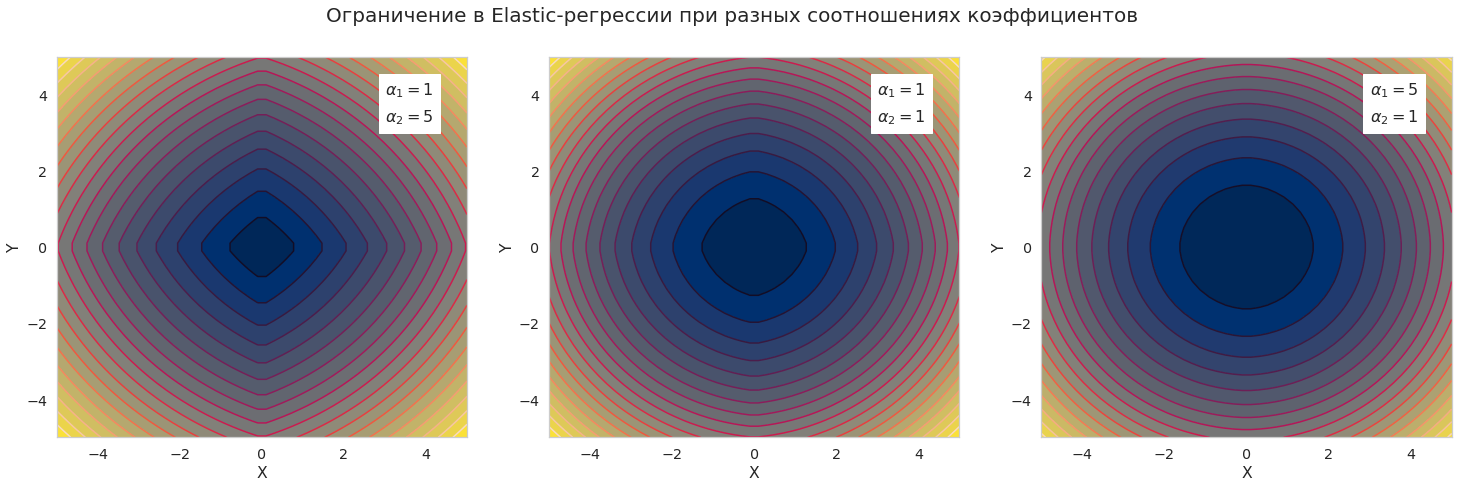

In [52]:
alpha_1 = 1
alpha_2 = 2

def get_f(alpha_1, alpha_2):
    def f(x, y):
        return alpha_1 * (x**2 + y**2) + alpha_2 * (np.abs(x) + np.abs(y))
    return f

x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)

X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(1, 3, figsize=(25, 7))
for i, (alpha_1, alpha_2) in enumerate([(1, 5), (1, 1), (5, 1)]):
    Z = get_f(alpha_1, alpha_2)(X, Y)
    ax = axs[i]
    ax.contourf(X, Y, Z, 20, cmap='cividis')
    ax.contour(X, Y, Z, 20, color='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.annotate(f'$\\alpha_1 = {alpha_1}$', (3, 4), backgroundcolor='w', size=16)
    ax.annotate(f'$\\alpha_2 = {alpha_2}$', (3, 3.3), backgroundcolor='w', size=16)

# fig.legend()
fig.suptitle("Ограничение в Elastic-регрессии при разных соотношениях коэффициентов", fontsize=20)
fig.show()

## Задача 2.

Вам предлагается изучить и сравнить свойства линейных регрессионных моделей: обычной и с регуляризациями &mdash; Lasso, Ridge, Elastic Net.  

При выполнении задания воспользуйтесь готовыми реализациями методов в sklearn.

Скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, в которых используйте следующие столбцы:
* `City` &mdash; город, данные для которого приводятся.
* `Cost of Living Index` &mdash; является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` &mdash; это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` &mdash; это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` &mdash; сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` &mdash; показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` &mdash; это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

In [38]:
data = pd.read_csv('https://dasl.datadescription.com/download/data/3136', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]
data.sample(7)

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
353,53.19,15.59,35.06,47.05,108.14,43.22
306,63.34,27.45,46.03,63.83,152.26,64.13
189,74.10,26.05,50.93,62.04,141.87,80.28
2,134.83,71.70,104.38,129.74,130.96,138.98
300,64.94,11.57,39.20,61.77,48.72,52.32
489,33.86,7.29,21.05,29.75,77.33,30.30
181,74.72,35.67,55.89,74.26,94.22,73.92


**1.** Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров. Разделите данные на признаки $X$ и таргет $y$.

In [72]:
Y_train = data.loc[:, 'Groceries Index']
X_train_unscaled = data.loc[:, data.columns != 'Groceries Index']

Разбейте данные на обучающую и тестирующие выборки в соотношении 7:3 с помощью `train_test_split`</a> из sklearn. Далее везде вплоть до сравнения моделей используйте обучающую выборку.

In [73]:
X_train_unscaled, X_test_unscaled, Y_train, Y_test = train_test_split(X_train_unscaled, Y_train, random_state=42, train_size=0.3)

Методы с регуляризацией требуют страндартизации признаков. Поясните, почему это необходимо.

**Ответ:** иначе данные будут иметь разную размерность и иметь различный вклад в регуляризаторе

Примените стандартизацию к обучающей и тестовой выборкам, используя класс <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler">`StandardScaler`</a>, **обученный на обучающей выборке**.

In [74]:
scaler = StandardScaler().fit(X_train_unscaled)
X_train = scaler.transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

**2.** Исследуйте зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессий. Для Elastic также исследуйте зависимость от параметра `l1_ratio`. Нарисуйте графики, используя код с семинара. Предложите диапазоны значений, где стоило бы искать оптимальные параметры регуляризации.

In [58]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 6), l1_check=False):
    """
    Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации.
    
    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм 
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм 
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    if not l1_check:
        for a in alphas:
            if 'l1_ratio' in model.get_params():
                # равномерно распределим alpha по обоим коэффициентам
                a *= 3/2
                model.set_params(alpha=a)
            else:
                model.set_params(alpha=a)
            model.fit(X, y)
            coefs.append(model.coef_)
    else:
        for a in alphas:
            model.set_params(l1_ratio=a)
            model.fit(X, y)
            coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

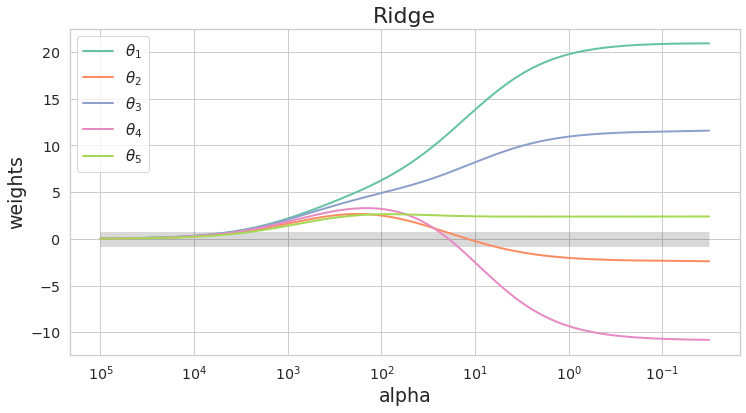

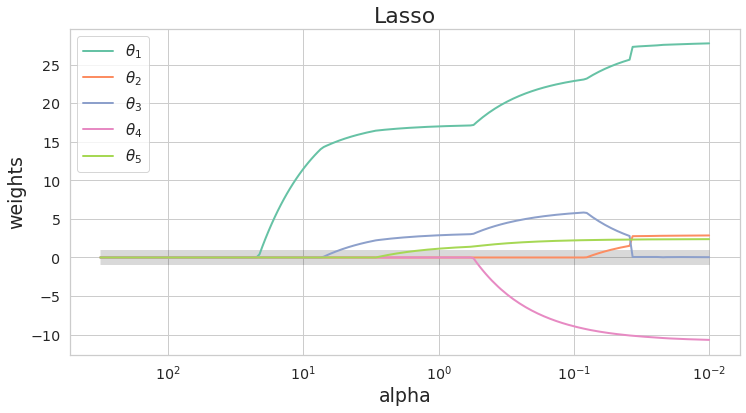

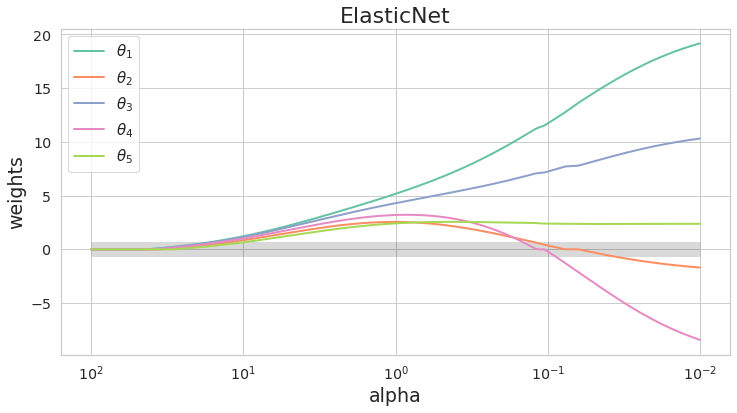

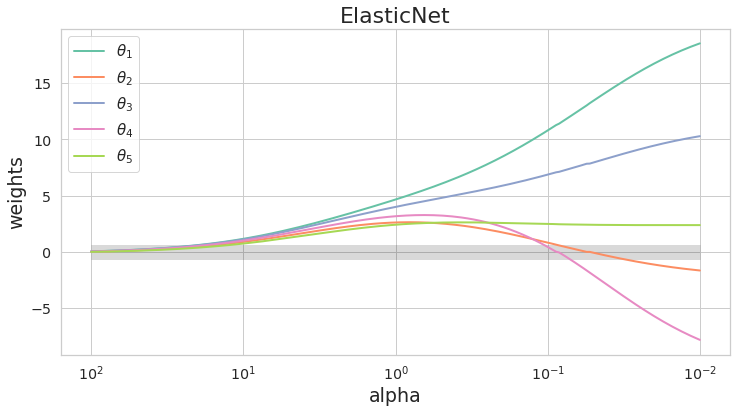

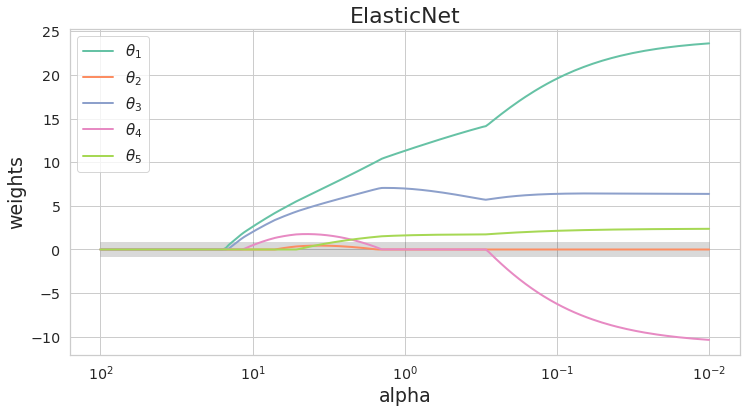

In [59]:
draw_track(Ridge(fit_intercept=False), X_train, Y_train, -1.5, 5, 200, 
           title='Ridge')
draw_track(Lasso(fit_intercept=False), X_train, Y_train, -2, 2.5, 200, 
           title='Lasso')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=1/3), X_train, Y_train, -2, 2, 200, 
           title='ElasticNet')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=1/10), X_train, Y_train, -2, 2, 200, 
           title='ElasticNet')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=15/16), X_train, Y_train, -2, 2, 200, 
           title='ElasticNet')

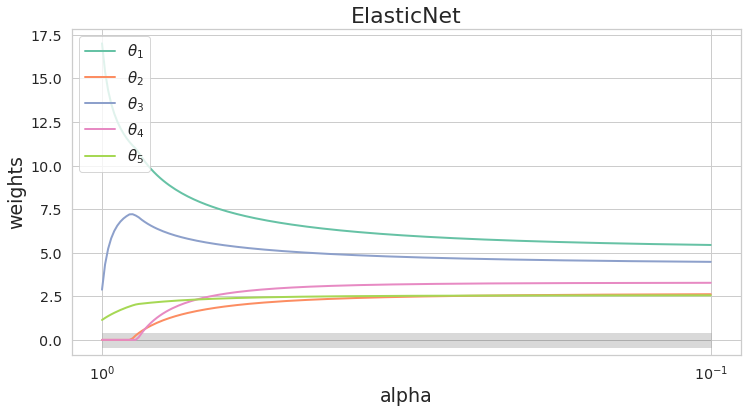

In [63]:
draw_track(ElasticNet(fit_intercept=False), X_train, Y_train, -1, 0, 200, 
           title='ElasticNet', l1_check=True)

Расчитайте индекс обусловленности для МНК-решения. Можно ли сделать вывод о мультиколлинеарности данных?  
Нарисуйте график зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии. 

In [55]:
XTX = X_train.T.dot(X_train)
eigvals = la.eigvals(XTX)
np.sqrt(np.abs(eigvals).max() / np.abs(eigvals).min())

13275.63259860821

Получилось что-то большое, это признак мультиколлинеарности в данных

**3.** С помощью кросс-валидации определите наилучшие параметры для Ridge, Lasso, Elastic моделей. В качестве метрики качества используйте среднеквадратичную ошибку (MSE).

*Замечание.* Не забудьте, что при стандартизации была использована вся обучающая выборка, а внутри кросс-валидации на каждой итерации рассматривается своя валидационная выборка, которая не должна стандартизироваться по данным, посчитанным частично на ней самой. Вам может помочь [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

(нагло копипастим с семинара)

#### Ridge

In [93]:
# задаем стратегию кросс-валидации
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

# задаем модель (порядок важен)
model = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])

# задаем пространство поиска
parameters_grid = {
    'model__alpha' : np.linspace(0.00001, 2, num=1000) # в Pipeline передаем параметры немного иначе
}

# определяем поиск по сетке 
grid_searcher = GridSearchCV(
    # модель для обучения, в нашем случае Ridge
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, берем MSE
    scoring='neg_mean_squared_error',
    # GridSearch отлично параллелится, указываем количество параллельных джоб
    # -1 означает использование всех ядер
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=ss,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=5,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [94]:
grid_searcher.fit(X_train_unscaled, Y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 2.01199199e-03, 4.01398398e-03, 6.01597598e-03,
       8.01796797e-03, 1.00199600e-02, 1.20219520e-02, 1.40239439e-02,
       1.602...
       1.95395418e+00, 1.95595618e+00, 1.95795817e+00, 1.95996016e+00,
       1.96196215e+00, 1.96396414e+00, 1.96596614e+00, 1.96796813e+00,
       1.96997012e+00, 1.97197211e+00, 1.97397410e+00, 1.97597610e+00,
       1.97797809e+00, 1.97998008e+00, 1.98198207e+00, 1.98398406e+00,
       1.98598606e+00, 1.98798805e+00, 1.98999004e+00, 1.99199203e+00,
       1.99399402e+00, 1.99599602e+00, 1.99799801e+00, 2.00000000e+00])},
             scoring='neg_mean_squared_error', verbose=5)

In [97]:
ridge_alpha_best = grid_searcher.best_params_['model__alpha']
ridge_best = grid_searcher.best_estimator_
grid_searcher.best_score_, ridge_alpha_best, ridge_best

(-37.03161040172033,
 1.52752988988989,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', Ridge(alpha=1.52752988988989))]))

#### Lasso

In [98]:
# задаем стратегию кросс-валидации
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

# задаем модель (порядок важен)
model = Pipeline([('scaler', StandardScaler()), ('model', Lasso())])

# задаем пространство поиска
parameters_grid = {
    'model__alpha' : np.linspace(0.00001, 2, num=1000) # в Pipeline передаем параметры немного иначе
}

# определяем поиск по сетке 
grid_searcher = GridSearchCV(
    # модель для обучения, в нашем случае Ridge
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, берем MSE
    scoring='neg_mean_squared_error',
    # GridSearch отлично параллелится, указываем количество параллельных джоб
    # -1 означает использование всех ядер
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=ss,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=5,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [99]:
grid_searcher.fit(X_train_unscaled, Y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 2.01199199e-03, 4.01398398e-03, 6.01597598e-03,
       8.01796797e-03, 1.00199600e-02, 1.20219520e-02, 1.40239439e-02,
       1.602...
       1.95395418e+00, 1.95595618e+00, 1.95795817e+00, 1.95996016e+00,
       1.96196215e+00, 1.96396414e+00, 1.96596614e+00, 1.96796813e+00,
       1.96997012e+00, 1.97197211e+00, 1.97397410e+00, 1.97597610e+00,
       1.97797809e+00, 1.97998008e+00, 1.98198207e+00, 1.98398406e+00,
       1.98598606e+00, 1.98798805e+00, 1.98999004e+00, 1.99199203e+00,
       1.99399402e+00, 1.99599602e+00, 1.99799801e+00, 2.00000000e+00])},
             scoring='neg_mean_squared_error', verbose=5)

In [100]:
lasso_alpha_best = grid_searcher.best_params_['model__alpha']
lasso_best = grid_searcher.best_estimator_
grid_searcher.best_score_, lasso_alpha_best, lasso_best

(-37.08536229277897,
 0.16817732732732732,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', Lasso(alpha=0.16817732732732732))]))

#### Elastic

In [101]:
# задаем стратегию кросс-валидации
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

# задаем модель (порядок важен)
model = Pipeline([('scaler', StandardScaler()), ('model', ElasticNet(max_iter=2000))])

# задаем пространство поиска
parameters_grid = {
    'model__alpha' : np.linspace(0.00001, 2, num=32), # в Pipeline передаем параметры немного иначе
    'model__l1_ratio' : np.linspace(0.00001, 1, num=32)
}

# определяем поиск по сетке 
grid_searcher = GridSearchCV(
    # модель для обучения, в нашем случае Ridge
    estimator=model,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, берем MSE
    scoring='neg_mean_squared_error',
    # GridSearch отлично параллелится, указываем количество параллельных джоб
    # -1 означает использование всех ядер
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=ss,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=5,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [102]:
grid_searcher.fit(X_train_unscaled, Y_train)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', ElasticNet(max_iter=2000))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 6.45258065e-02, 1.29041613e-01, 1.93557419e-01,
       2.58073226e-01, 3.22589032e-01, 3.87104839e-01, 4....
       2.58071935e-01, 2.90329677e-01, 3.22587419e-01, 3.54845161e-01,
       3.87102903e-01, 4.19360645e-01, 4.51618387e-01, 4.83876129e-01,
       5.16133871e-01, 5.48391613e-01, 5.80649355e-01, 6.12907097e-01,
       6.45164839e-01, 6.77422581e-01, 7.09680323e-01, 7.41938065e-01,
       7.74195806e-01, 8.06453548e-01, 8.38711290e-01, 8.70969032e-01,
       9.03226774e-01, 9.35484516e-01, 9.67742258e-01, 1.00000000e+00])},
             scoring='neg_mean_squared_error', verbose=5)

In [103]:
elastic_alpha_best = grid_searcher.best_params_['model__alpha']
elastic_l1_ratio_best = grid_searcher.best_params_['model__l1_ratio']
elastic_best = grid_searcher.best_estimator_
grid_searcher.best_score_, alpha, elastic_l1_ratio_best, elastic_best

(-36.99283270679539,
 0.1290416129032258,
 0.9677422580645161,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  ElasticNet(alpha=0.1290416129032258,
                             l1_ratio=0.9677422580645161, max_iter=2000))]))

На тестовой части данных сравните качество моделей с оптимальными параметрами. Какая модель дала лучший результат?

In [ ]:
<...>

**4.** Исследуйте остатки модели Ridge-регрессии. Можно ли говорить о гомоскедастичности. Если нет, попытайтесь несложными преобразованиями признаков и отклика визуально прийти к гомоскедастичности.

In [ ]:
<...>

С помощью модели Ridge-регрессии постройте предсказательный интревал для наблюдаемого отклика уровня доверия $0.95$. Какой смысл имеет этот интервал? В чем его отличие от доверительного интервала? Посчитате долю точек выходящих за предсказательный интревал.

In [ ]:
<...>

**5.** Сделайте общий вывод по задаче.

## Задача 3.

В этой задаче вам предлагается расмотреть и сравнить две стратегии поиска оптимальных значений некоторого функционала: GridSearch и RandomSearch. В реальной жизни значение функционала &mdash; это значение целевой метрики качества, а оптимизация идет по гиперпараметрам некоторой модели машинного обучения. Коротко напомним, в чем же заключается каждая стратегия.

* GridSearch &mdash; полный перебор по сетке. Суть перебора по сетке заключается в следующем: вы задаете область значений гиперпараметров, которые хотите оптимизировать, обучаете все модели, которые возможно получить в рамках заданного пространства поиска гиперпараметров. Затем выбираете из данных моделей ту, которая дала наилучшее качество на кросс-валидации.
* RandomSearch &mdash; это стратегия, при которой рассматривается некоторая выборка из множества значений гиперпараметров. По умолчанию часто используется равномерное распределение. Лучшая модель выбирается так же на основе кросс-валидации.

Разберем сначала **одномерный случай**. Для этого рассмотрим следующую функцию.

In [ ]:
def f(x):
    return 5.2 - 5/(1+(3*(x))**2) - np.cos(x)/5

Поcтройте график функции $f(x)$ на отрезке $[-20, 20]$. В чем его особенность?

In [ ]:
<...>

Подумайте, какие проблемы могут возникнуть при поиске минимума этой функции, если используется поиск по сетке?

**Ответ:**  <...>

Рассмотрим **поиск по сетке** и проведем вычислительный эксперимент. Для этого будем генерировать случайное смещение из $U[-0.5, 0.5]$, а затем рассматривать смещенную на $x_0$ сетку размера $n$ на отрезке $[-10, 10]$, после чего поиском по сетке искать оптимальное значение $f$.

In [ ]:
# рассматриваемые размеры сеток
grid_size = np.arange(2, 1000)
n_experiments = 100  # количество экспериментов

In [ ]:
# массив для минимумов по сетке для текущего эксперимента
grid_min_f_trace = []

for _ in tqdm(range(n_experiments)):
    # случайное смещение сетки на [-0.5, 0.5]
    x_0 = <...>
    # массив для минимумов для текущего размера сетки
    grid_f_min = []
    # цикл по размеру сетки
    for n in grid_size:
        # сетка на [-10, 10] размера n
        grid = <...>
        # найденный по сетке со смещением x_0 минимум функции f
        f_min = <...>
        # сохраним минимум для сетки размера n
        grid_f_min.append(f_min)
    # сохраним минимумы текущего эксперимента
    grid_min_f_trace.append(grid_f_min)

Для нескольких экспериментов постройте графики значений минимума от количества точек в сетке. 
Для большей наглядности и информативности сразу **зафиксируйте диапазон значений по оси y**, а также отображайте графики в **логарифмическом масштабе**.

In [ ]:
<...>

Теперь рассмотрим **случайный поиск**. Снова проведем вычислительный эксперимент. Обратите внимание, что случайные точки для эксперимента мы генерируем один раз.

In [ ]:
# рассматриваемое количество случайных точек
random_size = np.arange(2, 1000)

In [ ]:
# массив для минимумов для текущего эксперимента
random_min_f_trace = []

# цикл по экспериментам
for _ in tqdm(range(n_experiments)):
    # случайное смещение на [-0.5, 0.5]
    x_0 = <...>
    # массив для минимумов для текущего количества точек
    random_min_f = []
    # сгенерируем случайные на [-10, 10] точки сразу
    points = <...>
    
    #цикл по количеству точек
    for n in random_size:
        # найденный по первым n случайным точкам со смещением x_0 минимум функции f
        f_min = <...>
        # сохранение результатов
        random_min_f.append(f_min)
        
    random_min_f_trace.append(random_min_f)

Снова для нескольких экспериментов постройте графики значений минимума от количества точек при случайном поиске.

In [ ]:
<...>

Сравним два метода. Для этого постройте график зависимости найденного минимума от количества точек (случайных или в сетке). Перед этим предварительно усредните результат по количеству экспериментов. Какие результаты у вас получились?

In [ ]:
<...>

Теперь расмотрим **двумерный случай**, для этого определим следующую функцию:

In [ ]:
def f(x, y,):
    return 5.4 - 5/(1+(3*x)**2) - np.cos(x)/5 - np.cos(y)/5

Постройте тепловую карту значений этой функции на $[-20, 20]^2$.

In [ ]:
<...>

Проведите эксперимент, аналогичный одномерному случаю. В случае поиска по сетке рассмотрите сетку размера $n$ на $[-10, 10]$ по каждой координате. Таким образом, общий размер сетки будет $n^2$. Для ускорения вычислений в случае случайного поиска будет достаточно рассмотреть только такое количество точек, которое соответствует рассмотренным размерам сетки (т.е. квадраты чисел).

Сравните результат с полученным ранее. Сделайте вывод.

In [ ]:
<...>

**Вывод:** <...>

## Задача 4.

В этой задаче вам предлагается реализовать регрессию Хьюбера, а также применить ее к данным с выбросами. Для начала реализуйте класс по шаблону снизу. Обратите внимание, что класс `HuberRegression` &mdash; наследник класса `BaseEstimator`, это с легкостью позволит использовать наш класс, например, в `GridSearchCV`.

In [ ]:
class HuberRegression(BaseEstimator):
    '''
    Класс, реализующий линейную регрессию, используя функцию потерь Хьюбера.
    '''
    
    def __init__(self, c=1, fit_intercept=True, max_iter=100):
        '''
        :param c: константа c из определения функции потерь Хьюбера
        :param fit_intercept: добавлять ли константный признак
        :param max_iter: макс. количество итераций процедуры оптимизации
        '''
        
        self.c = c
        self.fit_intercept = fit_intercept
        self.max_iter = max_iter        
        
    def fit(self, X, y):
        '''
        Функция обучения модели.
        
        :param X: матрица признаков
        :param y: значения целевой паременной
        '''
        
        <...>
        return self
        
    def predict(self, X):
        '''
        Функция применения модели.
        
        :param X: матрица признаков.
        :return pred: предсказание отклика для объектов из X
        '''
        
        pred = <...>
        return pred

**1.** Загрузите данные из файлов `train.csv`, `test.csv`. Не забудьте, что всю аналитику, а также процесс обучения и подбор гиперпараметров необходимо выполнять на обучающей выборке.

In [ ]:
<...>

Посмотрите на зависимость целевой переменной от каждого признака. Что можно сказать о наличии возможных выбросов? Какое влияние они могут оказать? 

In [ ]:
<...>

**2.** Обучите простую линейную регрессию и посчитайте качество на тестовой выборке по метрикам MSE, MAE и MAPE. Что можно сказать о качестве нашей модели?

In [ ]:
<...>

**3.** Теперь обучите линейную регресcию Хьюбера и посчитайте качество на тестовой части по метрикам MSE, MAE и MAPE. Что изменилось? 

In [ ]:
<...>

**4.** Используя кросс-валидацию, подберите оптимальное значение гиперпараметра $c$ нашей модели. Какую метрику стоит использовать? Почему?

In [ ]:
<...>

**5.** Для обучающей выборки постройте два графика (по графику на каждую модель), на которых изобразите зависимость истинного и предсказанного значения таргета от каждого признака. Что можно заметить на этих графиках?

In [ ]:
<...>

**Вывод:** <...>